In [1]:
# use the code release version for tracking and code modifications. use the
# CHANGELOG.md file to keep track of version features, and/or release notes.
# the version file is avaiable at project root directory, check the
# global configuration setting for root directory information.
# the file is already read and is available as `__version__`
__version__ = open("../VERSION", "rt").read() # bump codecov
print(f"Current Code Version: {__version__}") # TODO : author, contact

Current Code Version: v0.1


### Code Imports

In [ ]:
!pip install -r ../requirements.txt

import os     # miscellaneous os interfaces
import sys    # configuring python runtime environment
import datetime as dt
import time   # library for time manipulation, and logging
from pathlib import Path
import pickle # load/save model as a pickle file

import pandas as pd  # data manipulation and analysis
import numpy as np   # numerical operations
import torch         # pytorch library for tensor operations
import lightning as L

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

### Data Analysis Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%precision 5
%matplotlib inline
sns.set_style('whitegrid');
# plt.style.use('default-style'); # http://tinyurl.com/mpl-default-style

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 17) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.5f}'.format # float precisions

def to_seconds(time_obj):
    """
    Convert a time of day object into a number representing the number of seconds since the start of the day.
    
    Args:
        time_obj (datetime.time): Time of day object.
    
    Returns:
        float: Number of seconds since the start of the day.
    """
    return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second)

torch.manual_seed(42)

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [3]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = Path(ROOT) / "data" # the directory contains all data files
RAW_DATA = DATA / "raw"

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = DATA / "processed"

# OUTPUT_DIR = os.path.join(ROOT, "output")
# IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
# MODELS_DIR = os.path.join(OUTPUT_DIR, "savedmodels")

## Historic Price Data

The historic data, i.e., any data in time series format, can be read using `pd.read_*().set_index("date")` or use a custom function to read and process from the file.

In [121]:
from typing import Any, Dict, List
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
import pickle


class PowerwallDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_file: str,
        feature_columns: List[str],
        sequence_length: int,
        batch_size: int,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.data_file = data_file
        self.feature_columns = feature_columns
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.standard_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler(feature_range=(0, 1))

        # Load and preprocess data
        self.column_transformer = ColumnTransformer(
            transformers=[
                ("standard", self.standard_scaler, ["total_home_usage"]),
                (
                    "minmax",
                    self.minmax_scaler,
                    [col for col in feature_columns if col != "total_home_usage"],
                ),
            ]
        )
        self.column_transformer.set_output(transform="pandas")
        self.data = None

    # Create sequences for LSTM
    def create_sequences(self, dataframe: pd.DataFrame, sequence_length):
        dataset = dataframe.values

        features = []
        targets = []
        for i in range(len(dataset) - sequence_length):
            features.append(dataset[i : i + sequence_length])
            targets.append(dataset[i + sequence_length][-1])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            targets, dtype=torch.float32
        )  # features, targets

    def prepare_data(self):
        # Load and preprocess data
        df = pd.read_csv(PROCESSED_DATA / "time_series_data.csv", parse_dates=True)

        # Convert the "timestamp" column to datetime type
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert(
            "Australia/Sydney"
        )
        df["time_of_day"] = df["timestamp"].dt.time.apply(to_seconds)
        df["day_of_week"] = df["timestamp"].dt.day_of_week
        df["year"] = df["timestamp"].dt.year
        df["month"] = df["timestamp"].dt.month
        df["day"] = df["timestamp"].dt.day
        df["total_home_usage"] = df["total_home_usage"].interpolate(method="linear")
        df["total_battery_charge"] = df["total_battery_charge"].interpolate(
            method="linear"
        )
        df["total_battery_discharge"] = df["total_battery_discharge"].interpolate(
            method="linear"
        )
        df["total_grid_energy_exported"] = df["total_grid_energy_exported"].interpolate(
            method="linear"
        )
        df["total_battery_charge"] = df["total_battery_charge"].interpolate(
            method="linear"
        )
        df["total_solar_generation"] = df["total_solar_generation"].interpolate(
            method="linear"
        )
        df.drop(
            columns=[
                "total_battery_charge",
                "total_battery_charge",
                "total_grid_energy_exported",
            ],
            inplace=True,
        )
        assert (df.isnull().sum() == 0).all(), "Validate no missing values"

        data_to_resample = df[["timestamp", "total_home_usage"]]
        data_half_hourly = (
            data_to_resample.resample("30min", on="timestamp").sum().reset_index()
        )
        data_half_hourly["timestamp"] = pd.to_datetime(
            data_half_hourly["timestamp"], utc=True
        ).dt.tz_convert("Australia/Sydney")
        data_half_hourly["time_of_day"] = data_half_hourly["timestamp"].dt.time.apply(
            to_seconds
        )
        data_half_hourly["day_of_week"] = data_half_hourly["timestamp"].dt.day_of_week
        data_half_hourly["year"] = data_half_hourly["timestamp"].dt.year
        data_half_hourly["month"] = data_half_hourly["timestamp"].dt.month
        data_half_hourly["day"] = data_half_hourly["timestamp"].dt.day
        self.data = data_half_hourly

        # When using a column transformer, the column order is not preserved. To preseve the column order,
        # we set the out to be a dataframe so we can "fix" the order before returning it as an array.
        # See https://stackoverflow.com/a/77702955
        normalized_data = self.column_transformer.fit_transform(
            self.data[self.data["year"] == 2024][self.feature_columns]
        )
        print("ColumnTransformer fitted")
        normalized_data = normalized_data.rename(columns=lambda x: x.split("__", 1)[-1])
        normalized_data = normalized_data[self.feature_columns]

        # Create sequences for training
        features, targets = self.create_sequences(normalized_data, self.sequence_length)
        # features = features.to(device)
        # targets = targets.to(device)

        # Split data into training and validation sets
        train_size = int(0.8 * len(normalized_data))
        print(
            f"train_size: {train_size} valid_size: {len(normalized_data) - train_size}"
        )
        train_ds = TensorDataset(features[:train_size], targets[:train_size])
        valid_ds = TensorDataset(features[train_size:], targets[train_size:])

        self.trainloader = DataLoader(
            train_ds, batch_size=self.batch_size, num_workers=4, shuffle=True
        )
        self.validloader = DataLoader(
            valid_ds, batch_size=self.batch_size, num_workers=4, shuffle=False
        )

    def train_dataloader(self):
        return self.trainloader

    def val_dataloader(self):
        return self.validloader
    
    def target_scaler(self):
        return self.column_transformer.named_transformers_["standard"]

    def state_dict(self) -> Dict[str, Any]:
        # Create a custom state dict that includes both model parameters and the transformer
        state_dict = super().state_dict()
        column_transformer_data = pickle.dumps(self.column_transformer)
        state_dict["column_transformer"] = column_transformer_data
        return state_dict

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        # Load the transformer from the state dict
        column_transformer_data = state_dict.pop("column_transformer", None)
        if column_transformer_data:
            self.column_transformer = pickle.loads(column_transformer_data)
        return super().load_state_dict(state_dict)


SEQUENCE_LENGTH = 24 * 2  # Sequence length - 24 hours data
BATCH_SIZE = 300
FEATURE_COLUMNS = [
    # "year",
    "month",
    # "day",
    "day_of_week",
    "time_of_day",
    # "temperature",
    # "humidity",
    # "wind_speed",
    # "precipitation",
    # "cloud_cover",
    # "weather_description",
    "total_home_usage",
    # "grid_energy_export",
]
data_module = PowerwallDataModule(
    data_file=PROCESSED_DATA / "time_series_data.csv",
    feature_columns=FEATURE_COLUMNS,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
)

## The Model

In [122]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightning as L


from torch.optim import Adam
import torch.utils
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.utils.data


class LSTMModel(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.save_hyperparameters()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        xb, yb = batch
        preds = self(xb)
        loss = nn.MSELoss()(preds[:, 0], yb)
        self.log("train_loss", loss)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        xb, yb = batch
        preds = self(xb)
        loss = nn.MSELoss()(preds[:, 0], yb)
        self.log("val_loss", loss)
        return {"val_loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Training

In [123]:

FEATURE_COLUMNS = [
    # "year",
    "month",
    # "day",
    "day_of_week",
    "time_of_day",
    # "temperature",
    # "humidity",
    # "wind_speed",
    # "precipitation",
    # "cloud_cover",
    # "weather_description",
    "total_home_usage",
    # "grid_energy_export",
]
TARGET_COLUMN = ["total_home_usage"]
use_last_num_data_points = -1 # 24 * 2 * 30 * 15  # 12 months of data

sequence_length = 24 * 2  # Sequence length - 24 hours data
batch_size = 100  # Batch size for training
learning_rate = 0.001


# Hyperparameters

input_size = len(FEATURE_COLUMNS)
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Predicting one value (Energy consumption)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)



In [129]:
from lightning.pytorch.callbacks import ModelCheckpoint


# Set up the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="model_checkpoints",  # Directory where checkpoints are saved
    filename="power_consumption_model-{epoch:02d}-{val_loss:.2f}",  # Custom file name
    save_top_k=3,  # Save the top 3 models
    monitor="val_loss",  # Monitor the validation loss to determine the best model
    mode="min",  # Save models with the minimum validation loss
)

num_epochs = 2  # Number of training epochs

trainer = L.Trainer(
    max_epochs=num_epochs,
    accumulate_grad_batches=4,
    log_every_n_steps=20,
    accelerator="mps",
    callbacks=[checkpoint_callback],
)
trainer.fit(model, data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


ColumnTransformer fitted



  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 200 K  | train
1 | fc   | Linear | 129    | train
----------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.803     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


train_size: 10523 valid_size: 2631


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/eho/dev/energy-consumption-prediction/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/eho/dev/energy-consumption-prediction/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

ColumnTransformer saved: b'\x80\x04\x95*\x07\x00\x00\x00\x00\x00\x00\x8c#sklearn.compose._column_transformer\x94\x8c\x11ColumnTransformer\x94\x93\x94)\x81\x94}\x94(\x8c\x0ctransformers\x94]\x94(\x8c\x08standard\x94\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0eStandardScaler\x94\x93\x94)\x81\x94}\x94(\x8c\twith_mean\x94\x88\x8c\x08with_std\x94\x88\x8c\x04copy\x94\x88\x8c\x16_sklearn_output_config\x94}\x94\x8c\ttransform\x94\x8c\x06pandas\x94s\x8c\x10_sklearn_version\x94\x8c\x051.5.2\x94ub]\x94\x8c\x10total_home_usage\x94a\x87\x94\x8c\x06minmax\x94h\x08\x8c\x0cMinMaxScaler\x94\x93\x94)\x81\x94}\x94(\x8c\rfeature_range\x94K\x00K\x01\x86\x94h\x0f\x88\x8c\x04clip\x94\x89h\x10}\x94h\x12h\x13sh\x14h\x15ub]\x94(\x8c\x05month\x94\x8c\x0bday_of_week\x94\x8c\x0btime_of_day\x94e\x87\x94e\x8c\tremainder\x94\x8c\x04drop\x94\x8c\x10sparse_threshold\x94G?\xd3333333\x8c\x06n_jobs\x94N\x8c\x13transformer_weights\x94N\x8c\x07verbose\x94\x89\x8c\x19verbose_feature_names_out\x94\x88\x8c\x18force_int_remai

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


ColumnTransformer saved: b'\x80\x04\x95*\x07\x00\x00\x00\x00\x00\x00\x8c#sklearn.compose._column_transformer\x94\x8c\x11ColumnTransformer\x94\x93\x94)\x81\x94}\x94(\x8c\x0ctransformers\x94]\x94(\x8c\x08standard\x94\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0eStandardScaler\x94\x93\x94)\x81\x94}\x94(\x8c\twith_mean\x94\x88\x8c\x08with_std\x94\x88\x8c\x04copy\x94\x88\x8c\x16_sklearn_output_config\x94}\x94\x8c\ttransform\x94\x8c\x06pandas\x94s\x8c\x10_sklearn_version\x94\x8c\x051.5.2\x94ub]\x94\x8c\x10total_home_usage\x94a\x87\x94\x8c\x06minmax\x94h\x08\x8c\x0cMinMaxScaler\x94\x93\x94)\x81\x94}\x94(\x8c\rfeature_range\x94K\x00K\x01\x86\x94h\x0f\x88\x8c\x04clip\x94\x89h\x10}\x94h\x12h\x13sh\x14h\x15ub]\x94(\x8c\x05month\x94\x8c\x0bday_of_week\x94\x8c\x0btime_of_day\x94e\x87\x94e\x8c\tremainder\x94\x8c\x04drop\x94\x8c\x10sparse_threshold\x94G?\xd3333333\x8c\x06n_jobs\x94N\x8c\x13transformer_weights\x94N\x8c\x07verbose\x94\x89\x8c\x19verbose_feature_names_out\x94\x88\x8c\x18force_int_remai

In [130]:
print(f"Loading best model from {checkpoint_callback.best_model_path}")

model = PowerwallDataModule.load_from_checkpoint(checkpoint_callback.best_model_path)
d.column_transformer.named_transformers_["standard"]
# print(f"Loading best model from {checkpoint_callback.best_model_path}")
# model = LSTMModel.load_from_checkpoint(checkpoint_callback.best_model_path)

# import pickle
# b = pickle.dumps(data_module.column_transformer) # data_module.column_transformer.named_transformers_["standard"]

# s = pickle.loads(b)


Loading best model from /Users/eho/dev/energy-consumption-prediction/experiments/model_checkpoints/power_consumption_model-epoch=01-val_loss=0.68.ckpt
ColumnTransformer loaded: b'\x80\x04\x95*\x07\x00\x00\x00\x00\x00\x00\x8c#sklearn.compose._column_transformer\x94\x8c\x11ColumnTransformer\x94\x93\x94)\x81\x94}\x94(\x8c\x0ctransformers\x94]\x94(\x8c\x08standard\x94\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0eStandardScaler\x94\x93\x94)\x81\x94}\x94(\x8c\twith_mean\x94\x88\x8c\x08with_std\x94\x88\x8c\x04copy\x94\x88\x8c\x16_sklearn_output_config\x94}\x94\x8c\ttransform\x94\x8c\x06pandas\x94s\x8c\x10_sklearn_version\x94\x8c\x051.5.2\x94ub]\x94\x8c\x10total_home_usage\x94a\x87\x94\x8c\x06minmax\x94h\x08\x8c\x0cMinMaxScaler\x94\x93\x94)\x81\x94}\x94(\x8c\rfeature_range\x94K\x00K\x01\x86\x94h\x0f\x88\x8c\x04clip\x94\x89h\x10}\x94h\x12h\x13sh\x14h\x15ub]\x94(\x8c\x05month\x94\x8c\x0bday_of_week\x94\x8c\x0btime_of_day\x94e\x87\x94e\x8c\tremainder\x94\x8c\x04drop\x94\x8c\x10sparse_threshold\x

StandardScaler()

## Prediction

In [167]:
import torch
import pandas as pd
from datetime import timedelta, datetime


def generate_time_steps(start_datetime: datetime, num_steps: int):
    """
    Generates the last `num_steps` time steps from the given datetime.

    Args:
        start_datetime (datetime): The reference datetime.
        num_steps (int): Number of time steps to generate (default is 24).

    Returns:
        pd.DataFrame: DataFrame containing the month, time_of_day (seconds from start of the day),
                      day_of_week (0-6), and consumption (set to 0).
    """
    time_steps = []

    for i in range(num_steps):
        step_datetime = start_datetime - timedelta(minutes=i * 30)
        month = step_datetime.month
        time_of_day = (
            step_datetime.hour * 3600 + step_datetime.minute * 60 + step_datetime.second
        )  # seconds from start of day
        day_of_week = step_datetime.weekday()  # Monday is 0, Sunday is 6

        time_steps.append(
            {
                "timestamp": step_datetime,
                "month": month,
                "time_of_day": time_of_day,
                "day_of_week": day_of_week,
                "total_home_usage": 0,  # Target consumption is set to 0 for input generation
            }
        )

    # Reverse the order of the list since we generate the past timesteps from the reference datetime
    time_steps.reverse()

    return pd.DataFrame(time_steps)


class Prediction:
    def __init__(
        self,
        model: LSTMModel,
        sequence_length: int,
        feature_columns: List[str],
        column_transformer: ColumnTransformer,
    ):
        self.model = model
        self.sequence_length = sequence_length
        self.feature_columns = feature_columns
        self.column_transformer = column_transformer
        self.target_scaler = column_transformer.named_transformers_["standard"]

    def predict(self, start_datetime: datetime, predict_steps: int = 10):
        # Initialize the result list
        result = []

        # Generate the initial input data (past {sequence_length} time steps)
        input_data_df = generate_time_steps(start_datetime, self.sequence_length)

        # Transform/scale the input features
        input_features = self.column_transformer.transform(
            input_data_df[self.feature_columns]
        )
        input_features = input_features.rename(columns=lambda x: x.split("__", 1)[-1])

        # This makes sure the columns are in the right order.
        input_features = input_features[self.feature_columns]

        # Convert the input features to a tensor with shape (1, sequence_length, len(feature_columns))
        input_tensor = torch.tensor(
            input_features.values, dtype=torch.float32, device=self.model.device
        ).unsqueeze(0)
        assert input_tensor.shape == (
            1,
            self.sequence_length,
            len(self.feature_columns),
        )

        model.eval()

        # Predict for the next `predict_steps` time steps
        for i in range(predict_steps):
            # Make a prediction
            with torch.no_grad():
                prediction_from_model = model(input_tensor)
                transformed_prediction = self.target_scaler.inverse_transform(
                    prediction_from_model.cpu()
                )

                # Extract the predicted consumption value
                predicted_consumption = transformed_prediction[0, -1]

            # Get the next timestamp
            next_datetime = start_datetime + timedelta(minutes=30 * (i + 1))

            # Get the month, time_of_day, and day_of_week for the next timestep
            month = next_datetime.month
            time_of_day = (
                next_datetime.hour * 3600
                + next_datetime.minute * 60
                + next_datetime.second
            )
            day_of_week = next_datetime.weekday()

            # Store the result
            result.append(
                {
                    "timestamp": next_datetime,
                    "month": month,
                    "day_of_week": day_of_week,
                    "time_of_day": time_of_day,
                    "total_home_usage": predicted_consumption,
                }
            )

            # Update input_tensor for the next prediction by appending new feature data
            next_input_features = self.column_transformer.transform(
                pd.DataFrame([result[-1]])
            )
            next_input_features = next_input_features.rename(
                columns=lambda x: x.split("__", 1)[-1]
            )
            next_input_features = next_input_features[self.feature_columns]
            input_tensor = torch.cat(
                (
                    input_tensor[:, 1:, :],
                    torch.tensor(
                        next_input_features.values,
                        dtype=torch.float32,
                        device=self.model.device,
                    ).unsqueeze(0),
                ),
                dim=1,
            )

        # Convert the result into a DataFrame
        result_df = pd.DataFrame(result)

        return result_df


# Assume `model` is your trained LSTM model
current_datetime = datetime(2024, 10, 10, 14, 30)  # Example: October 4, 2024, 14:30

print(f"Loading best model from {checkpoint_callback.best_model_path}")

model = LSTMModel.load_from_checkpoint(checkpoint_callback.best_model_path)
data_module = PowerwallDataModule.load_from_checkpoint(
    checkpoint_callback.best_model_path
)
prediction = Prediction(
    model,
    data_module.sequence_length,
    data_module.feature_columns,
    data_module.column_transformer,
)
prediction.predict(current_datetime, predict_steps=30)


Loading best model from /Users/eho/dev/energy-consumption-prediction/experiments/model_checkpoints/power_consumption_model-epoch=01-val_loss=0.68.ckpt
ColumnTransformer loaded: b'\x80\x04\x95*\x07\x00\x00\x00\x00\x00\x00\x8c#sklearn.compose._column_transformer\x94\x8c\x11ColumnTransformer\x94\x93\x94)\x81\x94}\x94(\x8c\x0ctransformers\x94]\x94(\x8c\x08standard\x94\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0eStandardScaler\x94\x93\x94)\x81\x94}\x94(\x8c\twith_mean\x94\x88\x8c\x08with_std\x94\x88\x8c\x04copy\x94\x88\x8c\x16_sklearn_output_config\x94}\x94\x8c\ttransform\x94\x8c\x06pandas\x94s\x8c\x10_sklearn_version\x94\x8c\x051.5.2\x94ub]\x94\x8c\x10total_home_usage\x94a\x87\x94\x8c\x06minmax\x94h\x08\x8c\x0cMinMaxScaler\x94\x93\x94)\x81\x94}\x94(\x8c\rfeature_range\x94K\x00K\x01\x86\x94h\x0f\x88\x8c\x04clip\x94\x89h\x10}\x94h\x12h\x13sh\x14h\x15ub]\x94(\x8c\x05month\x94\x8c\x0bday_of_week\x94\x8c\x0btime_of_day\x94e\x87\x94e\x8c\tremainder\x94\x8c\x04drop\x94\x8c\x10sparse_threshold\x

timestamp  month  day_of_week  time_of_day  total_home_usage
0  2024-10-10 15:00:00     10            3        54000         570.50616
1  2024-10-10 15:30:00     10            3        55800         622.53528
2  2024-10-10 16:00:00     10            3        57600         666.25450
3  2024-10-10 16:30:00     10            3        59400         691.24843
4  2024-10-10 17:00:00     10            3        61200         701.93080
5  2024-10-10 17:30:00     10            3        63000         704.78825
6  2024-10-10 18:00:00     10            3        64800         704.39179
7  2024-10-10 18:30:00     10            3        66600         703.13862
8  2024-10-10 19:00:00     10            3        68400         701.99403
9  2024-10-10 19:30:00     10            3        70200         701.19511
10 2024-10-10 20:00:00     10            3        72000         700.69115
11 2024-10-10 20:30:00     10            3        73800         700.36345
12 2024-10-10 21:00:00     10            3        75600         700.11193
13 2024-10-10 21:30:00     10            3        77400         699.87520
14 2024-10-10 22:00:00     10            3        79200         699.62461
15 2024-10-10 22:30:00     10            3        81000         699.35194
16 2024-10-10 23:00:00     10            3        82800         699.05894
17 2024-10-10 23:30:00     10            3        84600         698.75077
18 2024-10-11 00:00:00     10            4            0         698.43260
19 2024-10-11 00:30:00     10            4         1800         692.17527
20 2024-10-11 01:00:00     10            4         3600         690.58427
21 2024-10-11 01:30:00     10            4         5400         693.02501
22 2024-10-11 02:00:00     10            4         7200         697.28937
23 2024-10-11 02:30:00     10            4         9000         701.68860
24 2024-10-11 03:00:00     10            4        10800         705.35837
25 2024-10-11 03:30:00     10            4        12600         708.04222
26 2024-10-11 04:00:00     10            4        14400         709.81357
27 2024-10-11 04:30:00     10            4        16200         710.87198
28 2024-10-11 05:00:00     10            4        18000         711.42829
29 2024-10-11 05:30:00     10            4        19800         711.65550

In [130]:
import torch
from datetime import timedelta


predict_from = datetime(2024, 9, 27, 0, 0, 0)

print(f"Loading best model from {checkpoint_callback.best_model_path}")
model = LSTMModel.load_from_checkpoint(checkpoint_callback.best_model_path)

def predict_next_step(sequence_df: pd.DataFrame):
    input_sequence = column_transformer.transform(sequence_df[FEATURE_COLUMNS])
    input_sequence = input_sequence.rename(columns=lambda x: x.split('__', 1)[-1])

    input_sequence_tensor = torch.tensor(input_sequence[FEATURE_COLUMNS].values, dtype=torch.float32, device=device).unsqueeze(0)
    prediction_from_model = learner.predict(input_sequence_tensor)
    transformed_prediction = target_scaler.inverse_transform(prediction_from_model.cpu())
    prediction = transformed_prediction[0, -1]
    return prediction

def predict_next_steps(sequence_df: pd.DataFrame, steps: int, on_new_row: Callable[[pd.DataFrame], None] = None):
    predictions = []
    for i in range(steps):
        prediction = predict_next_step(sequence_df)

        next_time = sequence_df[-1:]["timestamp"].to_numpy()[0].to_pydatetime() + timedelta(minutes=30)
        new_row = pd.DataFrame(
            {
                "timestamp": [next_time],
                "time_of_day": [to_seconds(next_time)],
                "year": [next_time.year],
                "month": [next_time.month],
                "day": [next_time.day],
                "day_of_week": [next_time.weekday()],
                "total_home_usage": [prediction],
            }
        )
        if on_new_row:
            on_new_row(new_row)
        sequence_df = pd.concat([sequence_df, new_row])[(-sequence_length):]
    return sequence_df


new_data = data[(-1):]
def append_to_data(new_row: pd.DataFrame):
    global new_data
    new_data = pd.concat([new_data, new_row])

predict_next_steps(data[(-sequence_length):], 2 * 24 * 30, on_new_row=append_to_data)


timestamp  total_home_usage  time_of_day  day_of_week  year  \
0 2024-10-30 01:00:00+11:00       1,151.52570         3600            2  2024   
0 2024-10-30 01:30:00+11:00       1,122.93338         5400            2  2024   
0 2024-10-30 02:00:00+11:00       1,141.23237         7200            2  2024   
0 2024-10-30 02:30:00+11:00       1,175.19558         9000            2  2024   
0 2024-10-30 03:00:00+11:00       1,196.28210        10800            2  2024   
0 2024-10-30 03:30:00+11:00       1,181.40509        12600            2  2024   
0 2024-10-30 04:00:00+11:00       1,126.65063        14400            2  2024   
0 2024-10-30 04:30:00+11:00       1,055.76123        16200            2  2024   
0 2024-10-30 05:00:00+11:00         998.43377        18000            2  2024   
0 2024-10-30 05:30:00+11:00         956.14784        19800            2  2024   
0 2024-10-30 06:00:00+11:00         919.26391        21600            2  2024   
0 2024-10-30 06:30:00+11:00         886.93358        23400            2  2024   
0 2024-10-30 07:00:00+11:00         860.63996        25200            2  2024   
0 2024-10-30 07:30:00+11:00         842.04864        27000            2  2024   
0 2024-10-30 08:00:00+11:00         833.60308        28800            2  2024   
0 2024-10-30 08:30:00+11:00         835.55925        30600            2  2024   
0 2024-10-30 09:00:00+11:00         844.34457        32400            2  2024   
0 2024-10-30 09:30:00+11:00         858.99675        34200            2  2024   
0 2024-10-30 10:00:00+11:00         889.79185        36000            2  2024   
0 2024-10-30 10:30:00+11:00         952.05363        37800            2  2024   
0 2024-10-30 11:00:00+11:00       1,049.30038        39600            2  2024   
0 2024-10-30 11:30:00+11:00       1,146.11352        41400            2  2024   
0 2024-10-30 12:00:00+11:00       1,173.58268        43200            2  2024   
0 2024-10-30 12:30:00+11:00       1,108.06483        45000            2  2024   
0 2024-10-30 13:00:00+11:00       1,022.17047        46800            2  2024   
0 2024-10-30 13:30:00+11:00         975.14710        48600            2  2024   
0 2024-10-30 14:00:00+11:00         969.40362        50400            2  2024   
0 2024-10-30 14:30:00+11:00         985.61594        52200            2  2024   
0 2024-10-30 15:00:00+11:00       1,010.10057        54000            2  2024   
0 2024-10-30 15:30:00+11:00       1,039.01641        55800            2  2024   
0 2024-10-30 16:00:00+11:00       1,071.94004        57600            2  2024   
0 2024-10-30 16:30:00+11:00       1,109.31784        59400            2  2024   
0 2024-10-30 17:00:00+11:00       1,154.45749        61200            2  2024   
0 2024-10-30 17:30:00+11:00       1,201.93409        63000            2  2024   
0 2024-10-30 18:00:00+11:00       1,218.24739        64800            2  2024   
0 2024-10-30 18:30:00+11:00       1,199.70591        66600            2  2024   
0 2024-10-30 19:00:00+11:00       1,174.55655        68400            2  2024   
0 2024-10-30 19:30:00+11:00       1,159.88203        70200            2  2024   
0 2024-10-30 20:00:00+11:00       1,152.54048        72000            2  2024   
0 2024-10-30 20:30:00+11:00       1,147.59182        73800            2  2024   
0 2024-10-30 21:00:00+11:00       1,142.86295        75600            2  2024   
0 2024-10-30 21:30:00+11:00       1,137.99115        77400            2  2024   
0 2024-10-30 22:00:00+11:00       1,133.10078        79200            2  2024   
0 2024-10-30 22:30:00+11:00       1,128.15350        81000            2  2024   
0 2024-10-30 23:00:00+11:00       1,124.37755        82800            2  2024   
0 2024-10-30 23:30:00+11:00       1,122.08863        84600            2  2024   
0 2024-10-31 00:00:00+11:00       1,119.69409            0            3  2024   
0 2024-10-31 00:30:00+11:00       1,207.09566         1800            3  2024   

   month  day  
0     10   30  
0     10   30  


In [131]:
# temp_data = df[(df['year'] == 2024) & (df['month'] == 9) & (df['day'] == 23)]
# t = temp_data["consumer_energy_imported_from_grid"] + temp_data["consumer_energy_imported_from_solar"] + temp_data["consumer_energy_imported_from_battery"] + temp_data["consumer_energy_imported_from_generator"]
# g = temp_data["grid_services_energy_imported"] + temp_data["grid_services_energy_exported"]
# # consumer_energy_imported_from_grid", "consumer_energy_imported_from_solar", "consumer_energy_imported_from_battery",        "consumer_energy_imported_from_generator"

# plt.figure()
# plt.plot(temp_data["total_home_usage_filled"])

# temp_data["time_of_day"]
new_data.head()

timestamp  total_home_usage  time_of_day  day_of_week  \
60350 2024-09-30 23:30:00+10:00         246.00000        84600            0   
0     2024-10-01 00:00:00+10:00         759.52793            0            1   
0     2024-10-01 00:30:00+10:00       1,156.88001         1800            1   
0     2024-10-01 01:00:00+10:00         969.16636         3600            1   
0     2024-10-01 01:30:00+10:00         798.23392         5400            1   

       year  month  day  
60350  2024      9   30  
0      2024     10    1  
0      2024     10    1  
0      2024     10    1  
0      2024     10    1

## Visualization

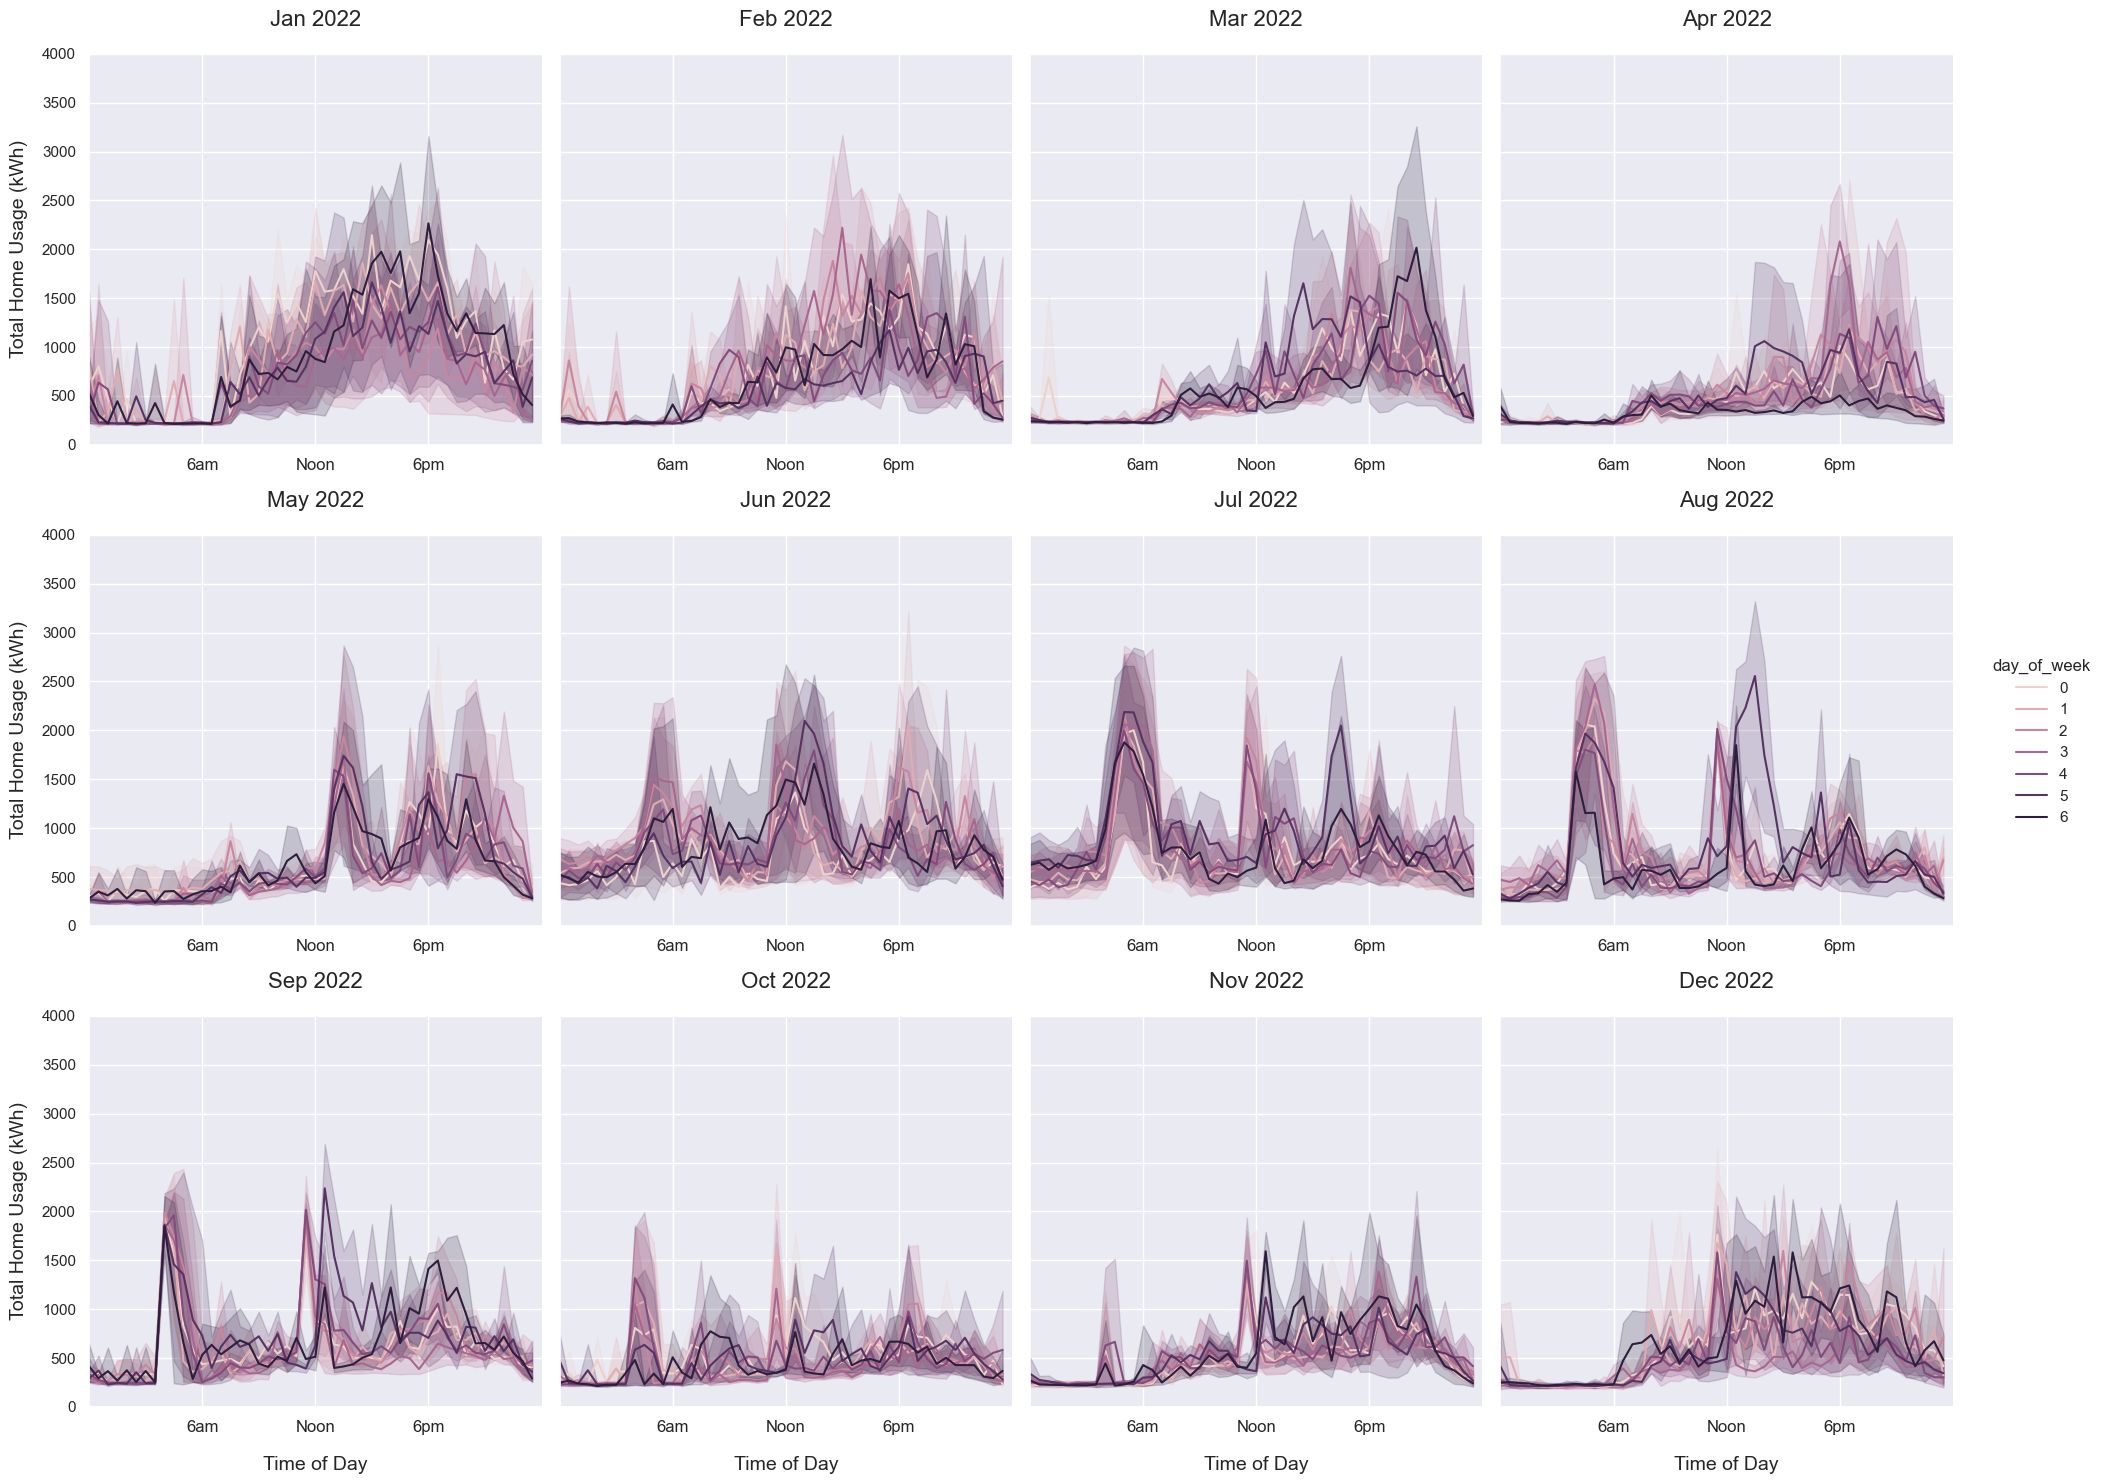

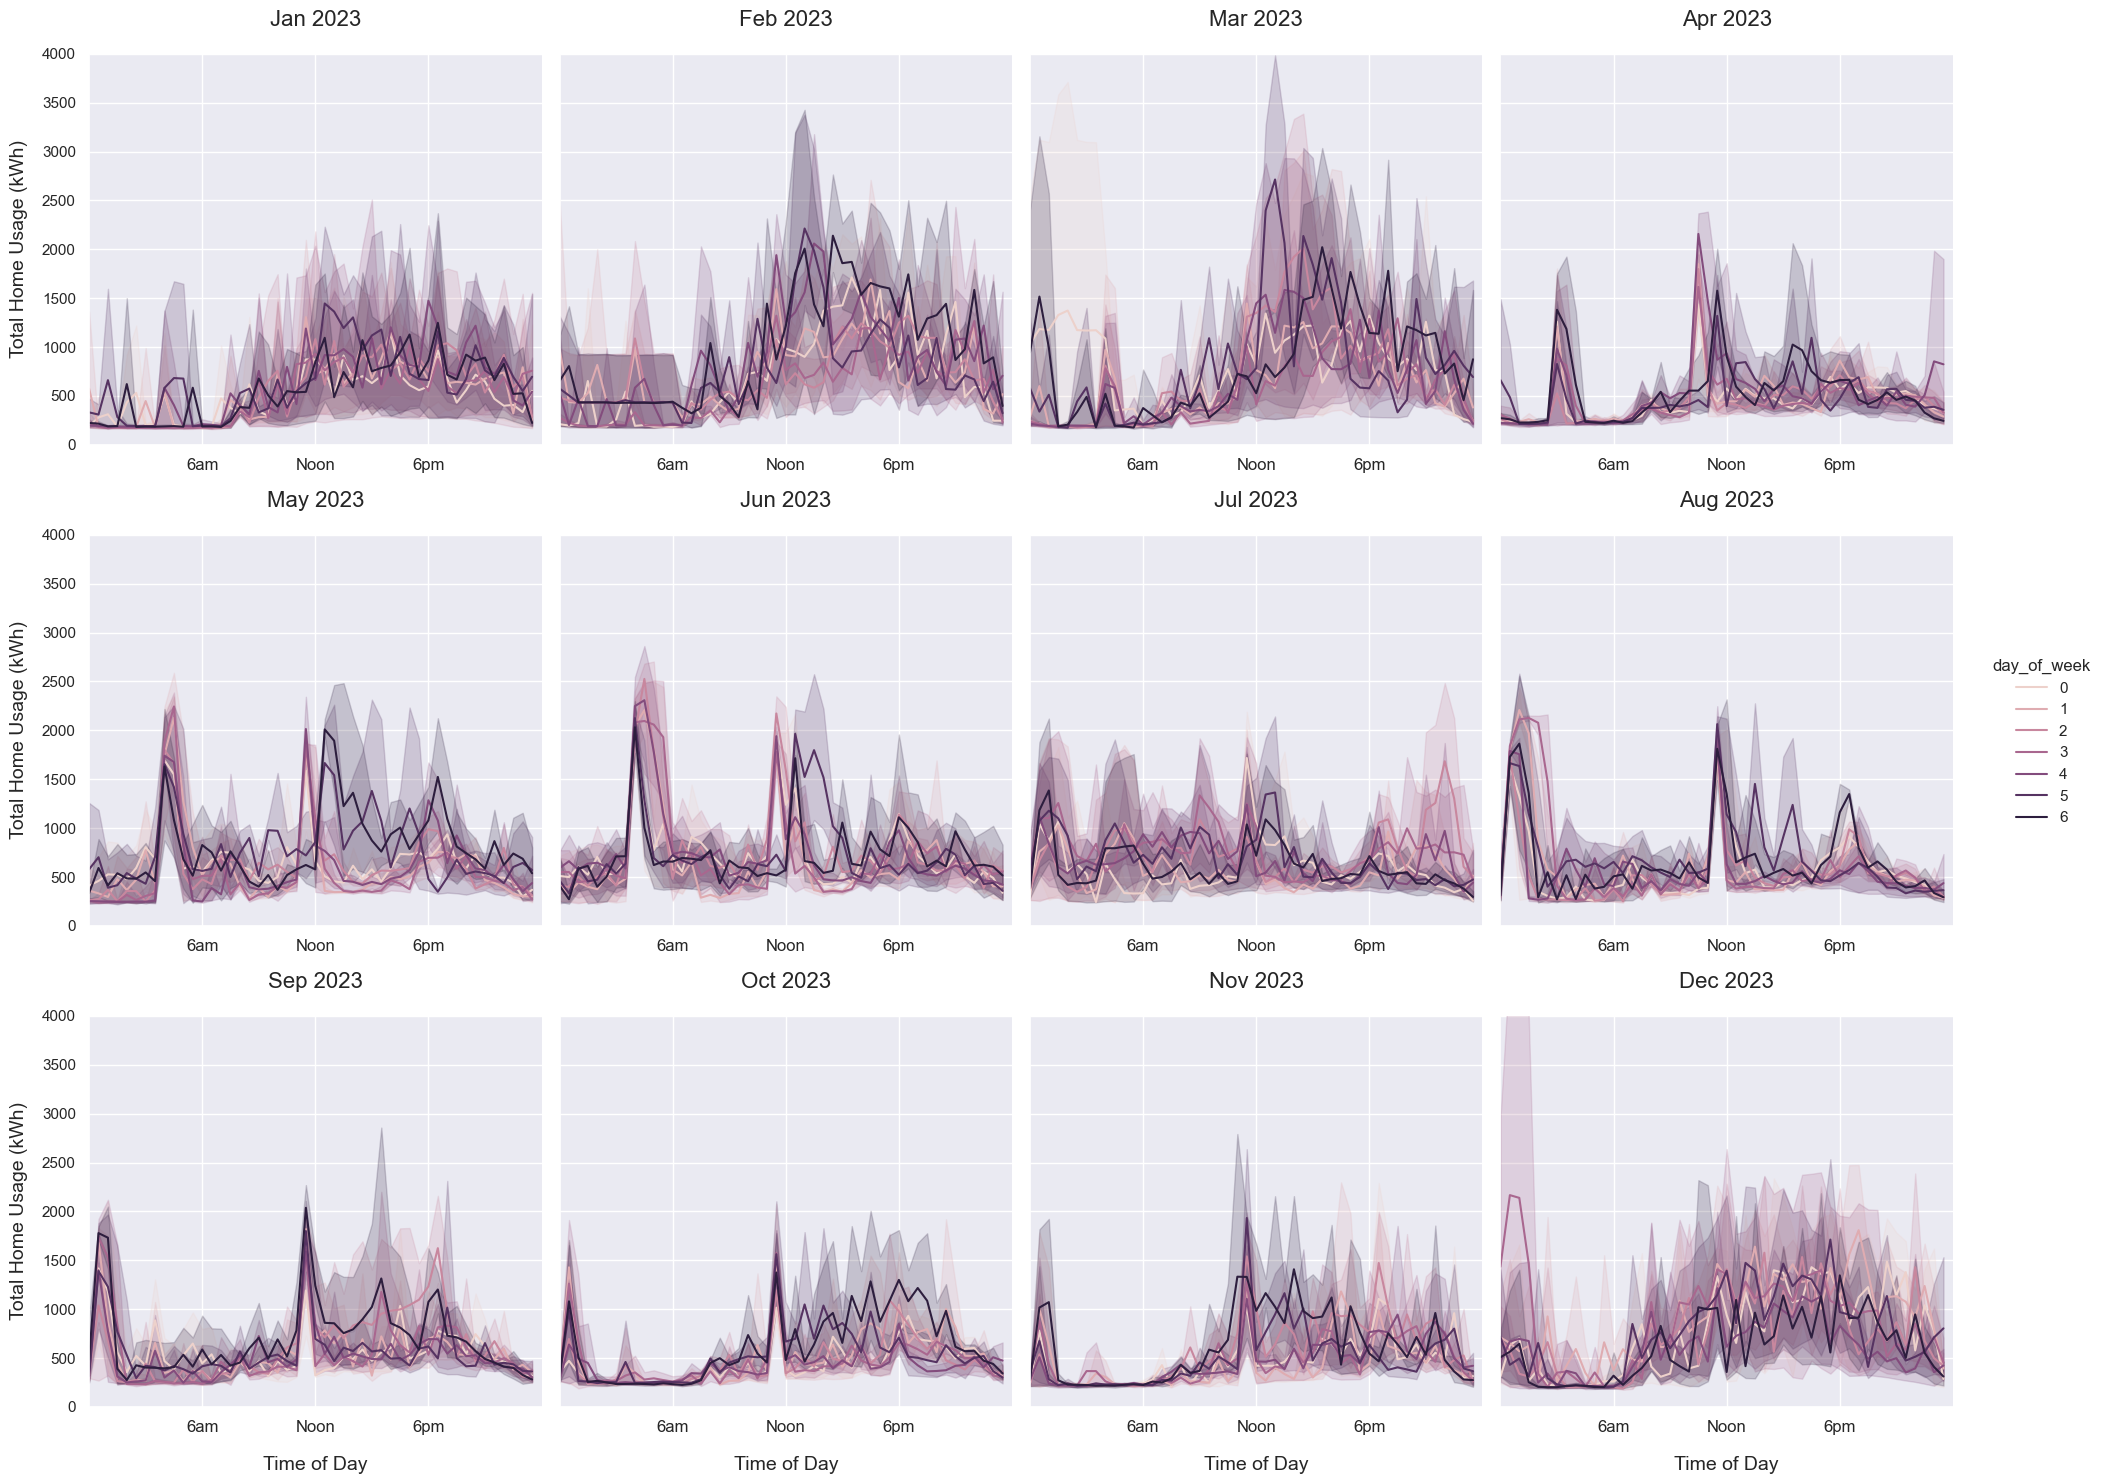

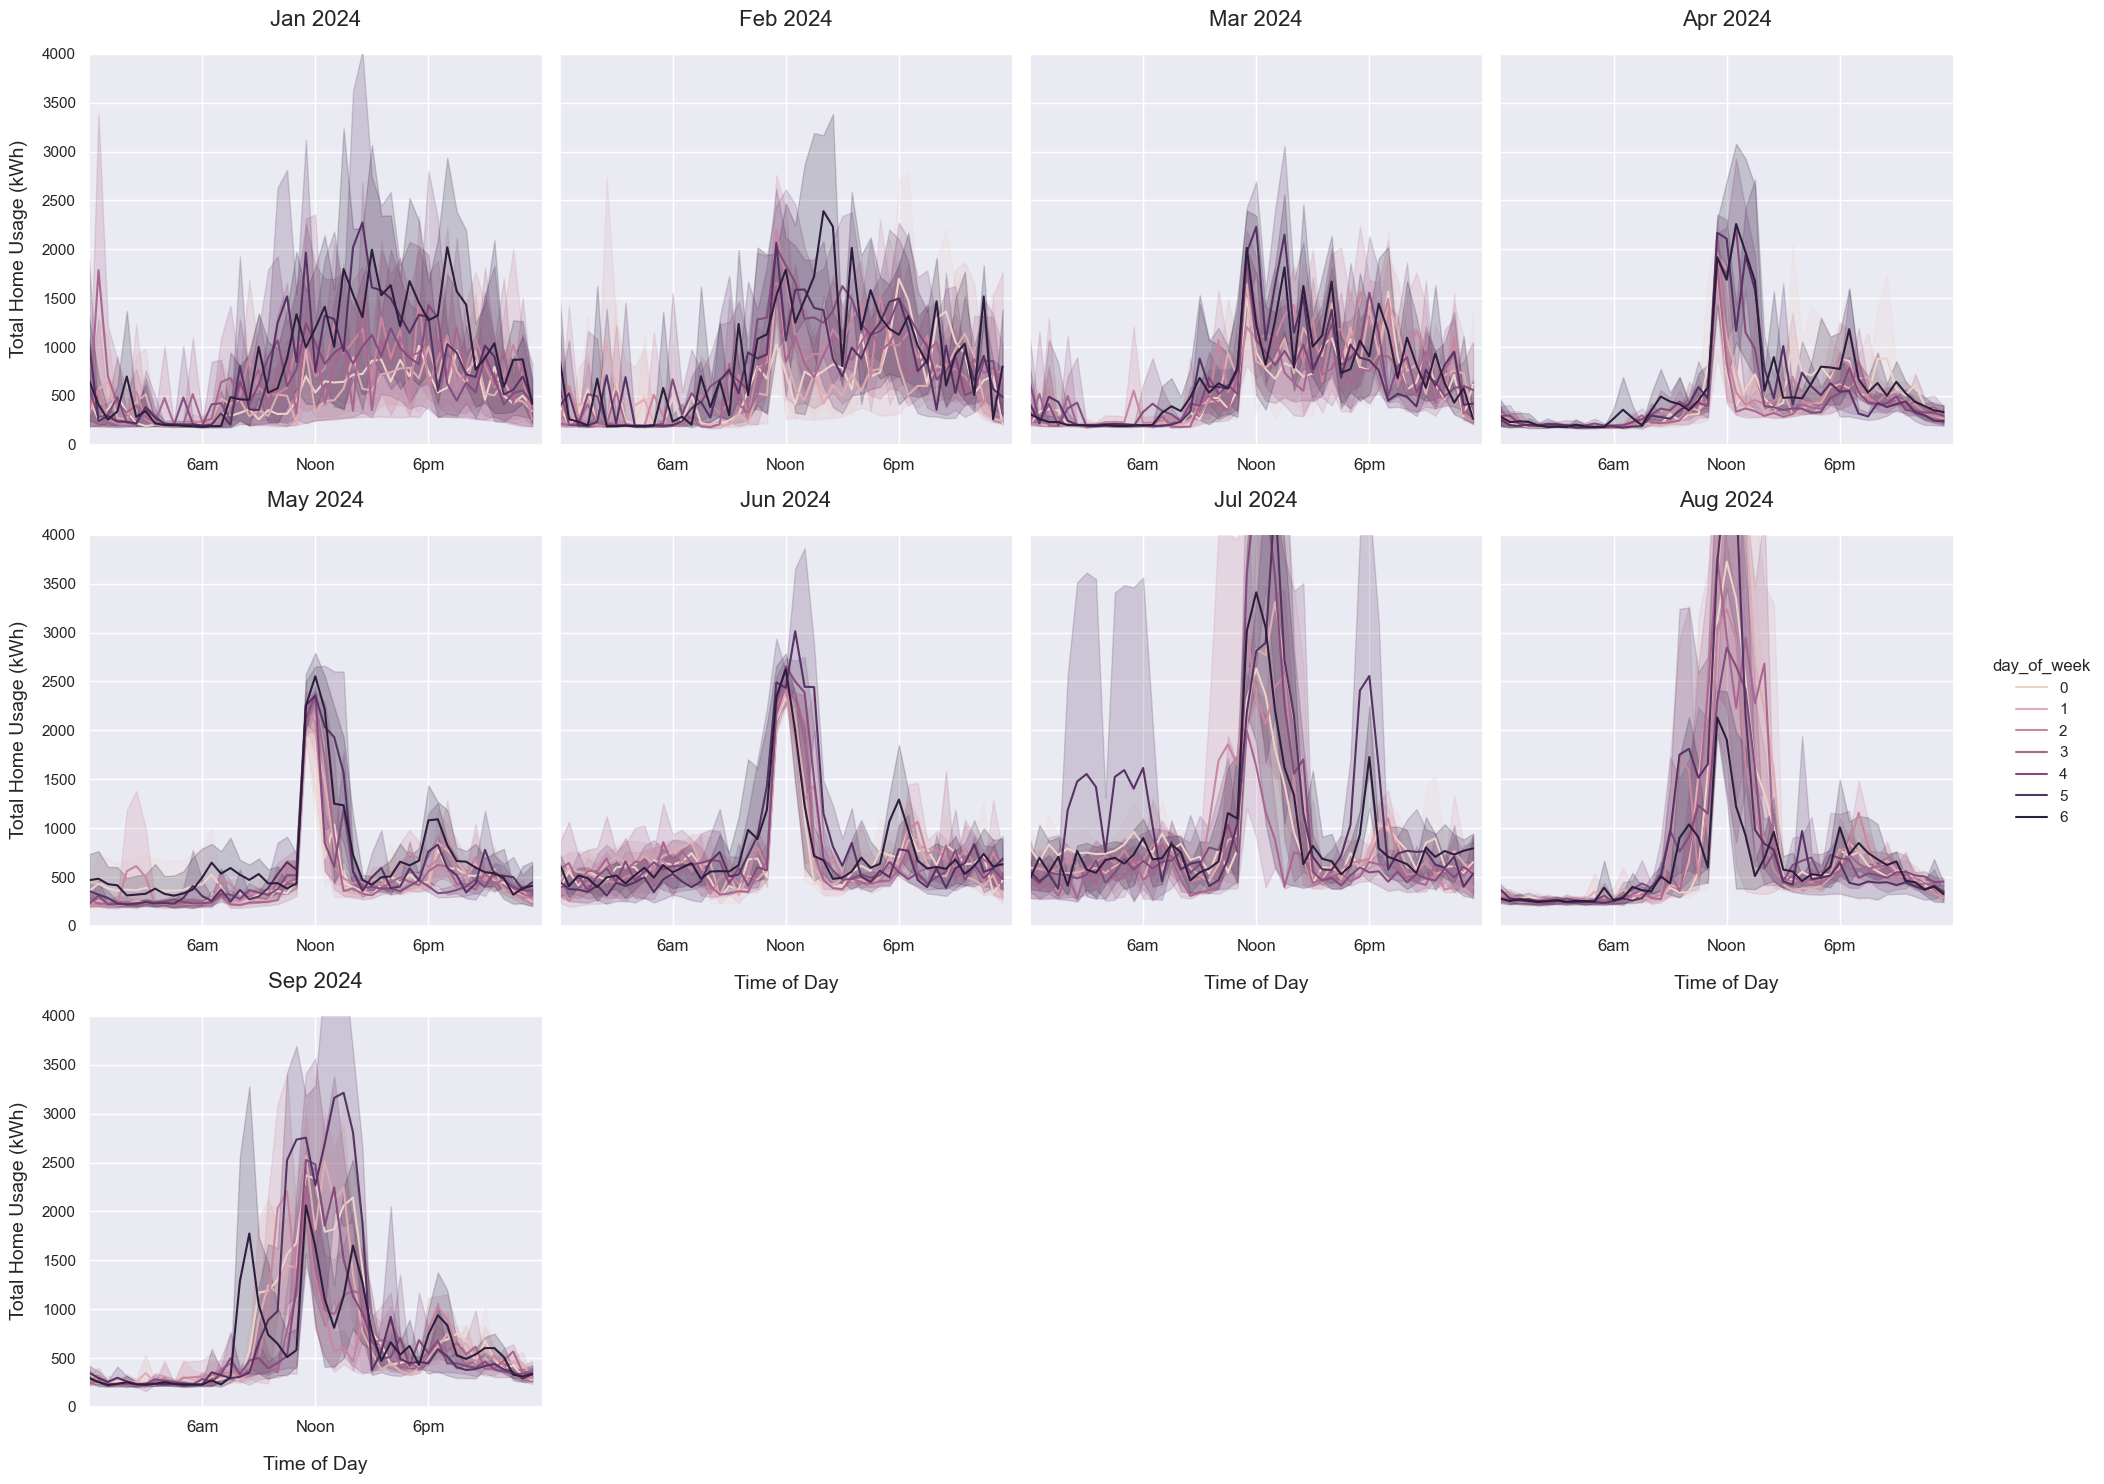

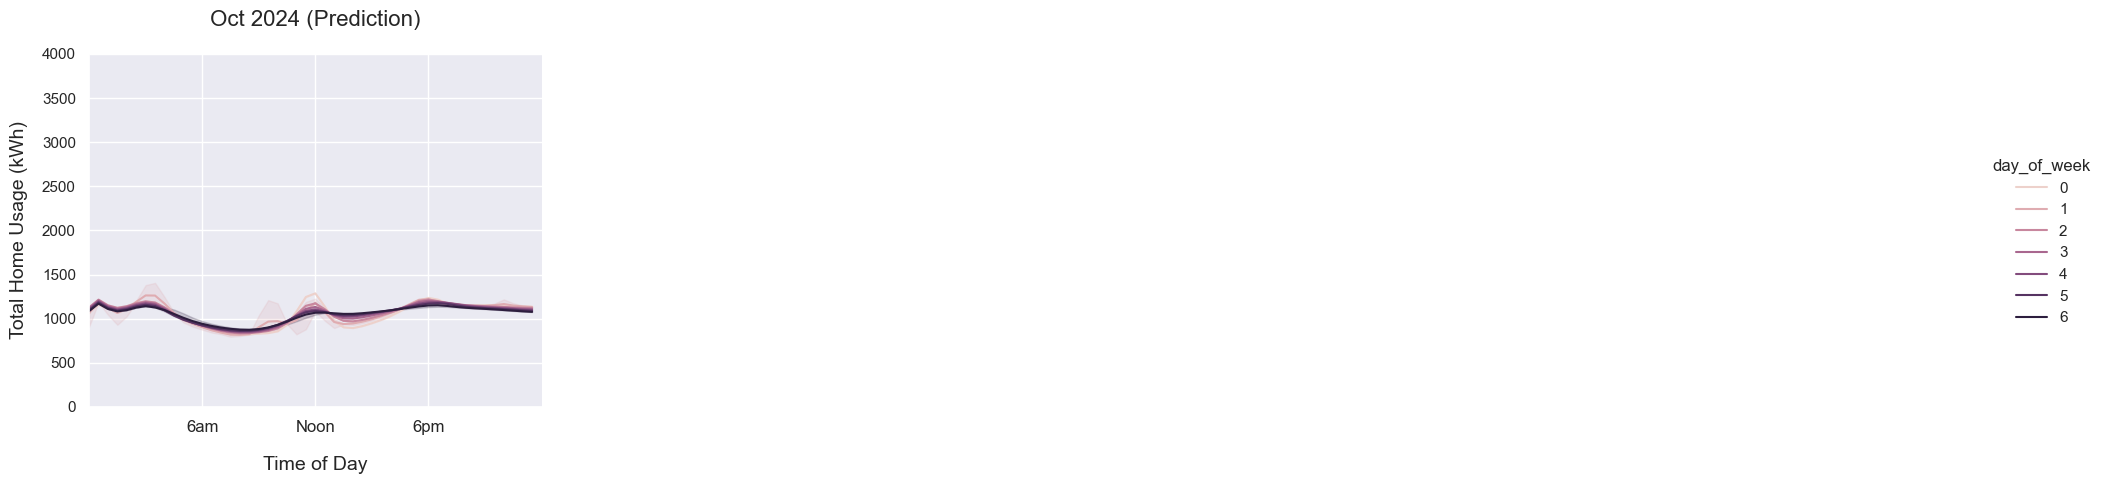

In [135]:
%matplotlib inline
from ipywidgets import interact
import matplotlib.cm as cm

sns.set_theme()
#sns.set_context("notebook")

def scale_hour_to_seconds(hour: int):
    return hour * 60 * 60

def plot_consumption(data: pd.DataFrame, year: int, title_suffix: str = None):
    def month_titles_for_year(year):
        return {
            1: f"Jan {year}",
            2: f"Feb {year}",
            3: f"Mar {year}",
            4: f"Apr {year}",
            5: f"May {year}",
            6: f"Jun {year}",
            7: f"Jul {year}",
            8: f"Aug {year}",
            9: f"Sep {year}",
            10: f"Oct {year}",
            11: f"Nov {year}",
            12: f"Dec {year}"
        }
    month_titles = month_titles_for_year(year)

    g = sns.relplot(
        data=data[(data["year"] == year)],
        kind="line",
        x="time_of_day",
        y="total_home_usage",
        hue="day_of_week",
        col="month",
        col_wrap=4,
        facet_kws={"palette": ["red"]}
    )

    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelbottom=True)  # Thi show x-axis labels on the bottom for all subplots
        ax.set_ylabel("Total Home Usage (kWh)", labelpad=10, fontsize=14)  # set y-axis label font size
        ax.set_xlabel("Time of Day", labelpad=15, fontsize=14)  # set x-axis label font size

        # Set x-axis tick label font size and rotation
        ax.tick_params(axis='x', labelsize=12)

        # Set x-axis and x-axis limits
        ax.set_xlim([0, 86400])  # set x-axis limits to 0-24
        ax.set_ylim(0, 4000)

        # Set custom x-axis tick labels
        ax.set_xticks([21600, 43200, 64800])  # set custom tick locations
        ax.set_xticklabels(['6am', 'Noon', '6pm'])  # set custom tick labels

        # Get the current month title
        month = int(ax.get_title().split("=")[1])

        # Customize the month title using the dictionary
        ax.set_title(month_titles[month] + (f" ({title_suffix})" if title_suffix else ""), pad=20, fontsize=16)
        
    g.tight_layout()
    return g


# plot_consumption(data, 2023)
g1 = plot_consumption(data, 2022)
g1 = plot_consumption(data, 2023)
g1 = plot_consumption(data, 2024)
g2 = plot_consumption(new_data[new_data["month"] == 10], 2024, "Prediction")

# # Create a new figure with enough subplots to accommodate all subplots
# fig = plt.figure(figsize=(12, 6))  # adjust the figure size as needed

# # Get the number of subplots in each relplot
# n1 = len(g1.axes.flat)
# n2 = len(g2.axes.flat)

# # Add subplots from the first relplot
# for i, ax in enumerate(g1.axes.flat):
#     new_ax = fig.add_subplot(2, 4, i+1)
#     new_ax.update_from(ax)  # transfer all axis properties
#     new_ax.set_xlim(ax.get_xlim())  # transfer x limits
#     new_ax.set_ylim(ax.get_ylim())  # transfer y limits
#     new_ax.set_title(ax.get_title())  # transfer title
#     new_ax.set_xlabel(ax.get_xlabel())  # transfer x label
#     new_ax.set_ylabel(ax.get_ylabel())  # transfer y label
    
#     new_ax.plot(ax.lines[0].get_xdata(), ax.lines[0].get_ydata())
#     ax.remove()  # remove the original axis

# # Add subplots from the second relplot
# colors = cm.rainbow(np.linspace(0, 1, len(g2.axes.flat)))
# for i, ax in enumerate(g2.axes.flat):
#     new_ax = fig.add_subplot(2, 4, n1+i+1)
#     new_ax.update_from(ax)  # transfer all axis properties
#     new_ax.set_xlim(ax.get_xlim())  # transfer x limits
#     new_ax.set_ylim(ax.get_ylim())  # transfer y limits
#     new_ax.set_title(ax.get_title() + " (Prediction)")
#     new_ax.set_xlabel(ax.get_xlabel())  # transfer x label
#     new_ax.set_ylabel(ax.get_ylabel())  # transfer y label
#     new_ax.plot(ax.lines[0].get_xdata(), ax.lines[0].get_ydata(), color='red')  # use a different color
#     ax.remove()  # remove the original axis

# # Layout so plots do not overlap
# fig.tight_layout()

# # Show the new figure
# plt.show()

# interact(update_g1, day=range(30))

In [133]:
import seaborn as sns

d = data_half_hourly[data_half_hourly["year"] == 2024]

sns.relplot(
    data=d,
    kind="line",
    x="time_of_day",
    y="total_home_usage_filled",
    hue="month",
    col="day_of_week",
    col_wrap=3,
)

ValueError: Could not interpret value `total_home_usage_filled` for `y`. An entry with this name does not appear in `data`.

In [32]:
import matplotlib.pyplot as plt
d = df[(df["year"] == 2024) & (df["month"] == 2) & (df["day"] == 13)]
# print(d.describe())
# print(d.columns)
# plt.plot(d["total_home_usage"])
import seaborn as sns

d.describe()

# sns.relplot(
#     data=d,
#     kind="line",
#     x="timestamp",
#     y="total_home_usage",
# )

d

date                 timestamp  solar_energy_exported  \
157865  2024-02-12 2024-02-13 00:00:00+11:00                0.00000   
157866  2024-02-12 2024-02-13 00:05:00+11:00                0.00000   
157867  2024-02-12 2024-02-13 00:10:00+11:00                0.00000   
157868  2024-02-12 2024-02-13 00:15:00+11:00                0.00000   
157869  2024-02-12 2024-02-13 00:20:00+11:00                0.00000   
157870  2024-02-12 2024-02-13 00:25:00+11:00                0.00000   
157871  2024-02-12 2024-02-13 00:30:00+11:00                0.00000   
157872  2024-02-12 2024-02-13 00:35:00+11:00                0.00000   
157873  2024-02-12 2024-02-13 00:40:00+11:00                0.00000   
157874  2024-02-12 2024-02-13 00:45:00+11:00                0.00000   
157875  2024-02-12 2024-02-13 00:50:00+11:00                0.00000   
157876  2024-02-12 2024-02-13 00:55:00+11:00                0.00000   

        generator_energy_exported  grid_energy_imported  \
157865                          0              38.00000   
157866                          0              39.00000   
157867                          0              33.00000   
157868                          0              29.00000   
157869                          0              33.00000   
157870                          0              37.00000   
157871                          0              37.00000   
157872                          0              32.00000   
157873                          0              27.00000   
157874                          0              31.00000   
157875                          0              37.00000   
157876                          0              37.00000   

        grid_services_energy_imported  grid_services_energy_exported  \
157865                              0                              0   
157866                              0                              0   
157867                              0                              0   
157868                              0                              0   
157869                              0                              0   
157870                              0                              0   
157871                              0                              0   
157872                              0                              0   
157873                              0                              0   
157874                              0                              0   
157875                              0                              0   
157876                              0                              0   

        grid_energy_exported_from_solar  ...  total_solar_generation  \
157865                          0.00000  ...                 4.00000   
157866                          0.00000  ...                 4.00000   
157867                          0.00000  ...                 4.00000   
157868                          0.00000  ...                 4.00000   
157869                          0.00000  ...                 4.00000   
157870                          0.00000  ...                 4.00000   
157871                          0.00000  ...                 4.00000   
157872                          0.00000  ...                 4.00000   
157873                          0.00000  ...                 4.00000   
157874                          0.00000  ...                 4.00000   
157875                          0.00000  ...                 4.00000   
157876                          0.00000  ...                 4.00000   

        total_home_usage  total_battery_discharge  time_of_day  day_of_week  \
157865          38.00000                 35.67206            0            1   
157866          39.00000                 35.68129          300            1   
157867          33.00000                 35.69053          600            1   
157868          29.00000                 35.69977          900            1   
157869          33.00000                 35.70901    